# Visualizing Subgraphs Top Interactions from Tweets Data with NetworkX

In [68]:
from __future__ import print_function
import graphistry
import snap
from snap import TUNGraph
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import networkx as nx
from math import sqrt
import operator
import community

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "9.GraphViz")

In [2]:
# Utility functions
def load_graph_from_backup(filename):
    FIn = snap.TFIn("../data/"+filename+".bin")
    graph = snap.TUNGraph.Load(FIn)
    return graph

def load_edges_df(hashtag):
    return pd.read_csv(os.path.join(data_dir,"graph_visualization_top_interactions/"+hashtag+"_top_interactions.csv"), dtype={"Source": np.object, "Target": np.object, "Count": np.uint32})

def load_nodes_df(hashtag):
    return pd.read_csv(os.path.join(data_dir,"graph_visualization_top_interactions/"+hashtag+"_users_frequency.csv"), dtype={"User": np.object, "Target": np.object, "Count": np.uint32})

In [3]:
# Hashtags
hashtags = ["jesuischarlie", "brexit","makeamericagreatagain","isis","imwithher","trump","blacklivesmatter","alllivesmatter","indyref"]
hashtags_full = ["JeSuisCharlie","Brexit","MAGA","ISIS","ImWithHer","Trump","BLM","ALM","IndyRef"]

## 1. Drawing Graphs

In [4]:
# Set colors by hashtag
colors = ["darksalmon","gold","seagreen","royalblue","purple","orange","tomato","slategrey","aquamarine"]
hashtag_color_dict = {h:k for h,k in zip(hashtags,colors)}

In [66]:
# Set cmaps by hashtag
cmaps = [plt.cm.RdPu,plt.cm.Wistia,plt.cm.Greens,plt.cm.Blues,plt.cm.Purples,plt.cm.Oranges,plt.cm.Reds,plt.cm.Greys,plt.cm.GnBu]
hashtag_cmap_dict = {h:k for h,k in zip(hashtags,cmaps)}

In [25]:
hashtag_subgraphs = {h:load_graph_from_backup("mmr_subgraph_"+h) for h in hashtags}

In [5]:
hashtag_graph_df_dict = {h:{"Edges": load_edges_df(h), "Nodes": load_nodes_df(h)} for h in hashtags}

In [80]:
# Plot graph
def draw_graph(hashtag, hashtag_full, hashtag_graph_df_dict, hashtag_cmap_dict):
    # Get needed data
    nodes_df = hashtag_graph_df_dict[hashtag]["Nodes"]
    edges_df = hashtag_graph_df_dict[hashtag]["Edges"]
    
    # Build graph from list of edges
    G = nx.Graph()
    G.add_weighted_edges_from(edges_df.values)
    
    # Build dict of node attrs (node size == degree)
    nodes_attr = {}
    for _,r in nodes_df.iterrows():
        nodes_attr[r["User"]] = r["Count"]
    nodes_attr = {k:nodes_attr[k] for k in nodes_attr if G.has_node(k)}
    
    # Build dict of edge attrs (edge weight == frequency of interaction)
    edges_attr = {}
    for _,r in edges_df.iterrows():
        edges_attr[(r["Source"],r["Target"])] = r["Count"]
        
    # Set figure properties
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,6)
    fig.set_dpi(150)
    ax.axis('off')
    ax.set_title(r"#%s Subgraph Top Interactions ($N=%d$, $E = %d$)" %(hashtag_full, len(G.nodes()), len(G.edges())))
    fig.set_tight_layout(False)

    # Compute nodes size and normalize data (and sort nodes list and sizes by size)
    nodes_list = [n for n in G.nodes()]
    nodes_size = [nodes_attr[n] if n in nodes_attr else 100 for n in nodes_list]
    nodes_size = [(1000-50)*(x-min(nodes_size))*1.0/(max(nodes_size)-min(nodes_size))+50 for x in nodes_size]
    temp = sorted(zip(nodes_list, nodes_size), key=operator.itemgetter(1))
    nodes_list = map(lambda x: x[0], temp)
    nodes_size = map(lambda x: x[1], temp)

    # Compute edges weight (width) and normalize data
    edges_list = edges_attr.keys()
    edges_weight = [(5-1)*(edges_attr[e]-min(edges_attr.values()))*1.0/(max(edges_attr.values())-min(edges_attr.values()))+1 for e in edges_list]

    # Set layout
    pos = nx.spring_layout(G,k=15/sqrt(len(G.nodes)))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos=pos,ax=ax,with_labels=False, nodelist=nodes_list, node_size=nodes_size, linewidths=1, edgecolors="k", alpha=0.9, node_color=range(len(G.nodes())), cmap=hashtag_cmap_dict[hashtag])

    # Draw edges with different color for those edges whose width is above average
    avg_edge_weight = edges_df["Count"].describe()["mean"]
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edgelist=edges_list,width=edges_weight, alpha=0.7)
    important_edges = [e for e in edges_attr.keys() if edges_attr[e] >= avg_edge_weight]
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edgelist=important_edges, alpha=0.7, edge_color="r", width=6)

    # Only draw labels for most influencing nodes (high degree and nodes belonging to high width edges)
    node_labels = {n:n for n in nodes_attr.keys() if nodes_attr[n] >= nodes_df["Count"].describe()["mean"]}
    for _,r in edges_df.iterrows():
        if r["Count"] >= avg_edge_weight:
            for c in ["Source","Target"]:
                if not r[c] in node_labels:
                    node_labels[r[c]] = r[c]

    # Get position of labels, not to be in the center of the nodes but a bit above them
    pos_attrs = {}
    for node, coords in pos.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
    #nx.draw_networkx_labels(G, pos_attrs, ax=ax, labels=node_labels, font_size=8)

    plt.savefig(os.path.join(pictures_path,hashtag+"_top_interactions.png"))
    plt.show()

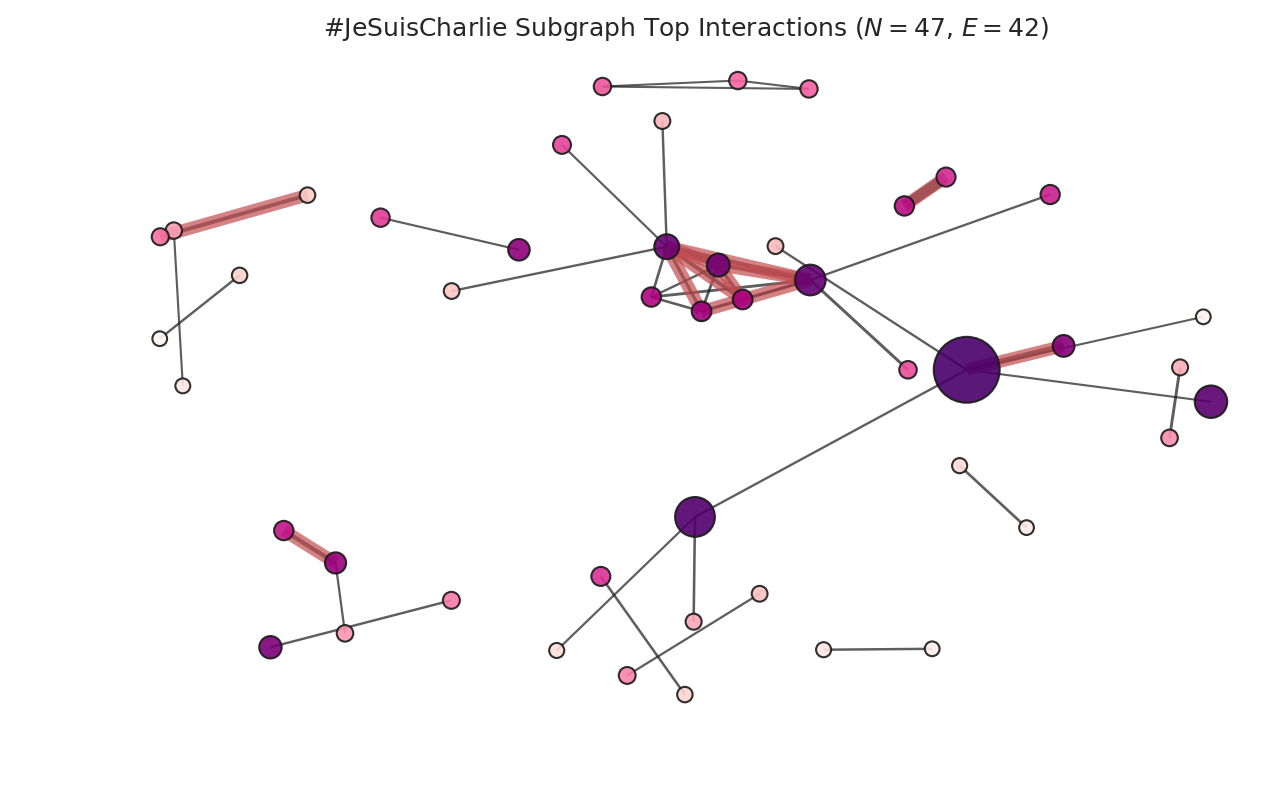

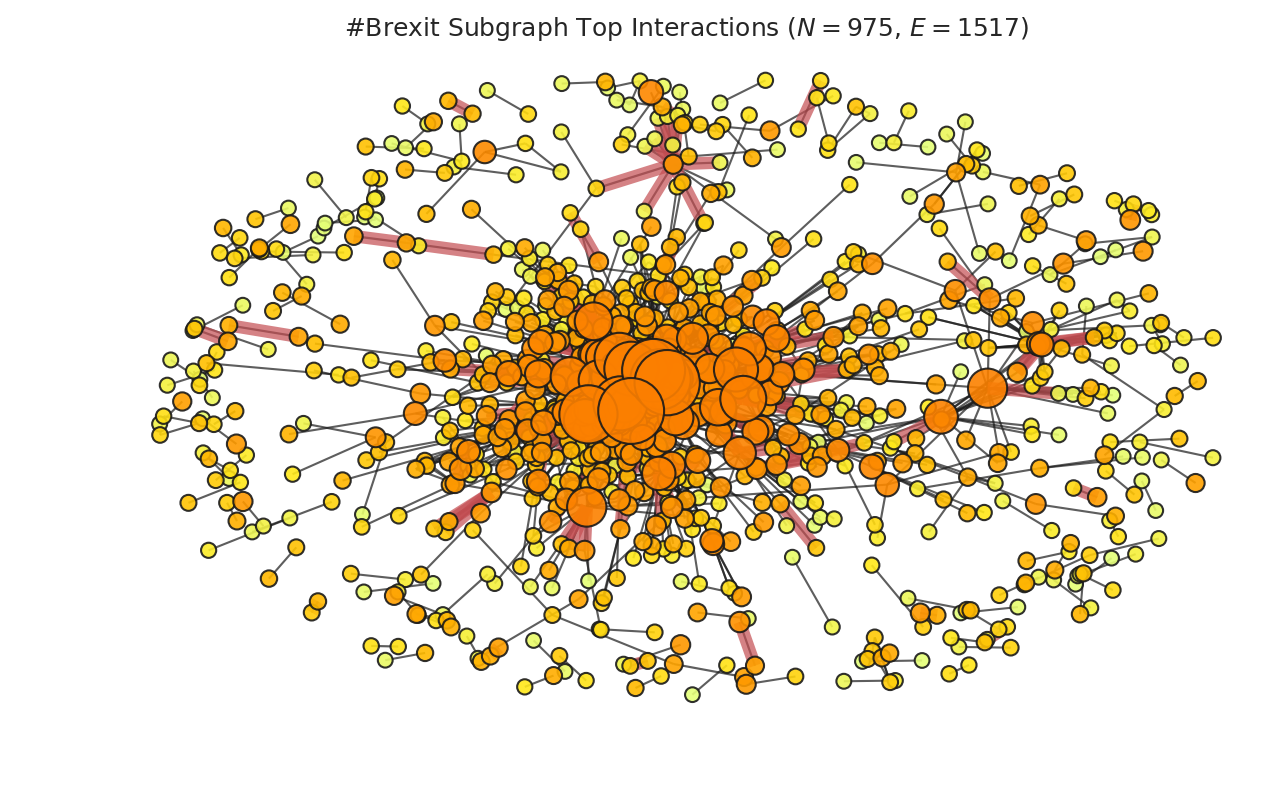

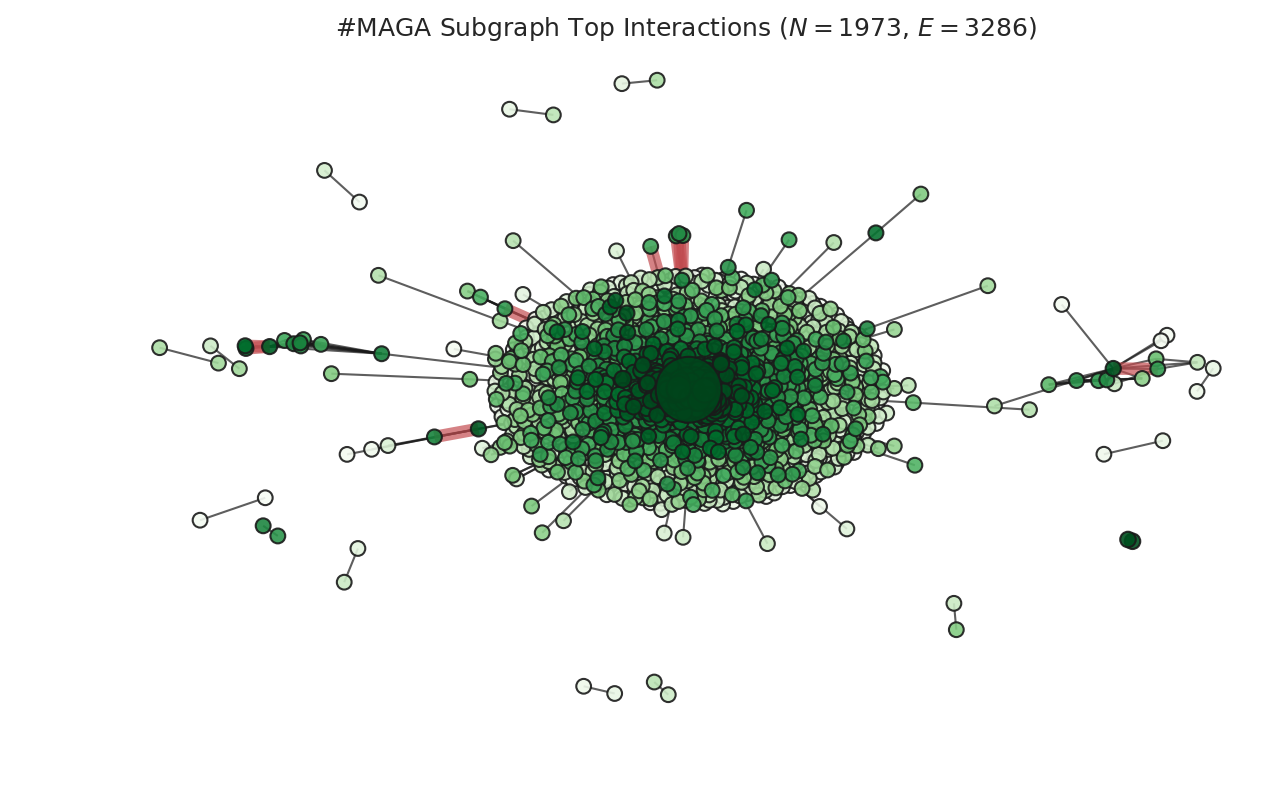

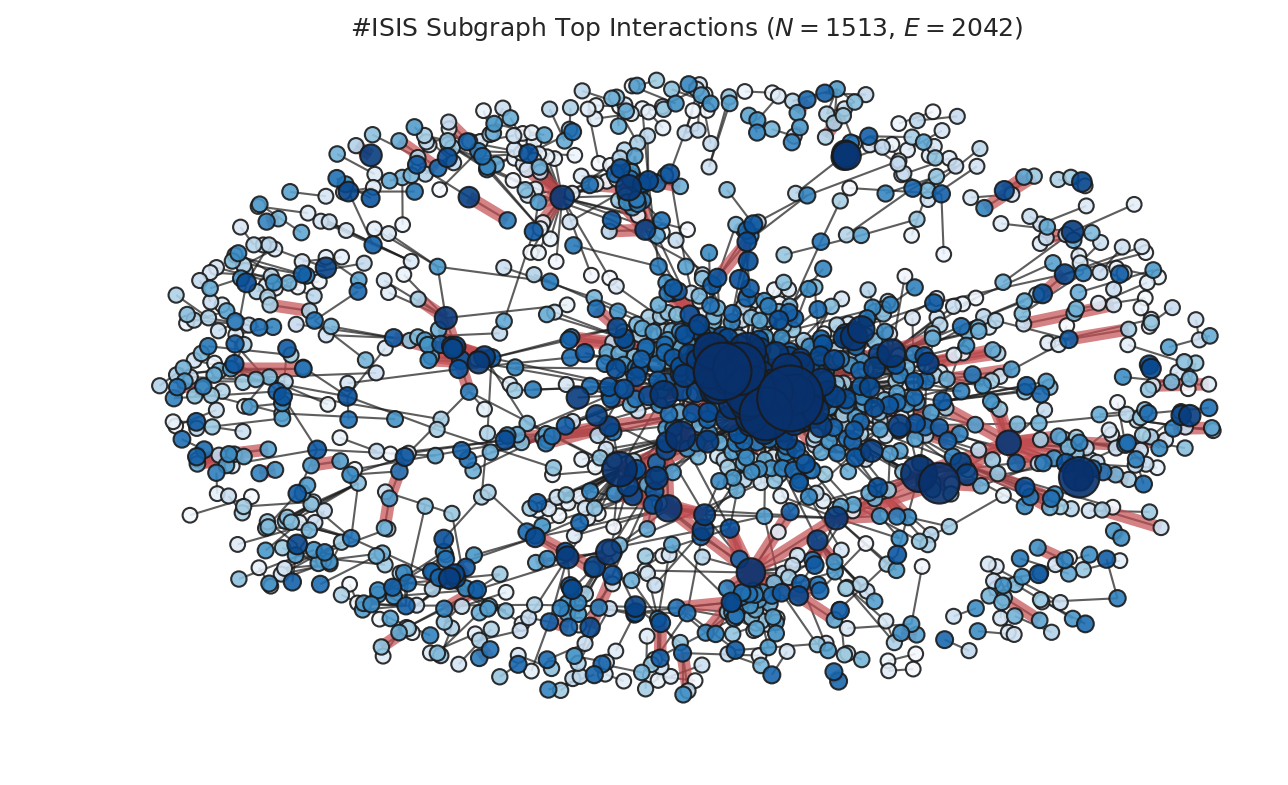

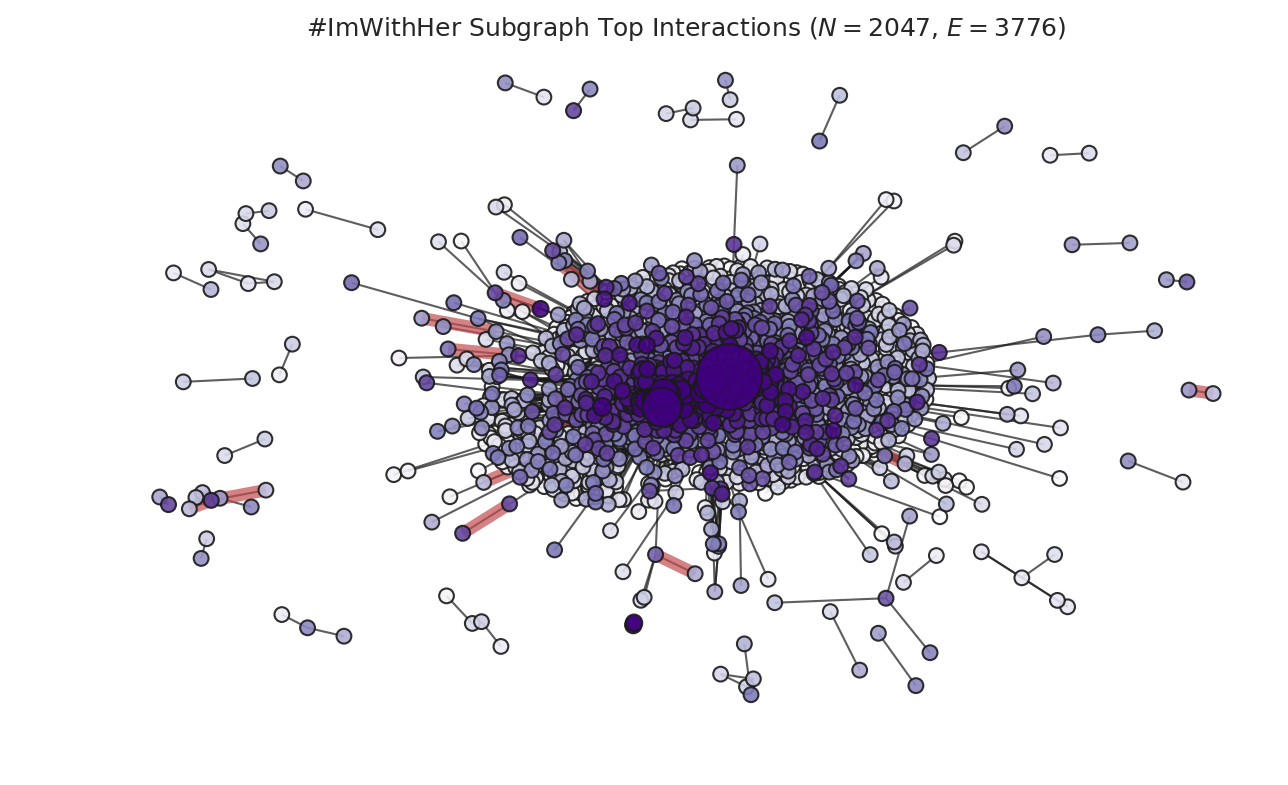

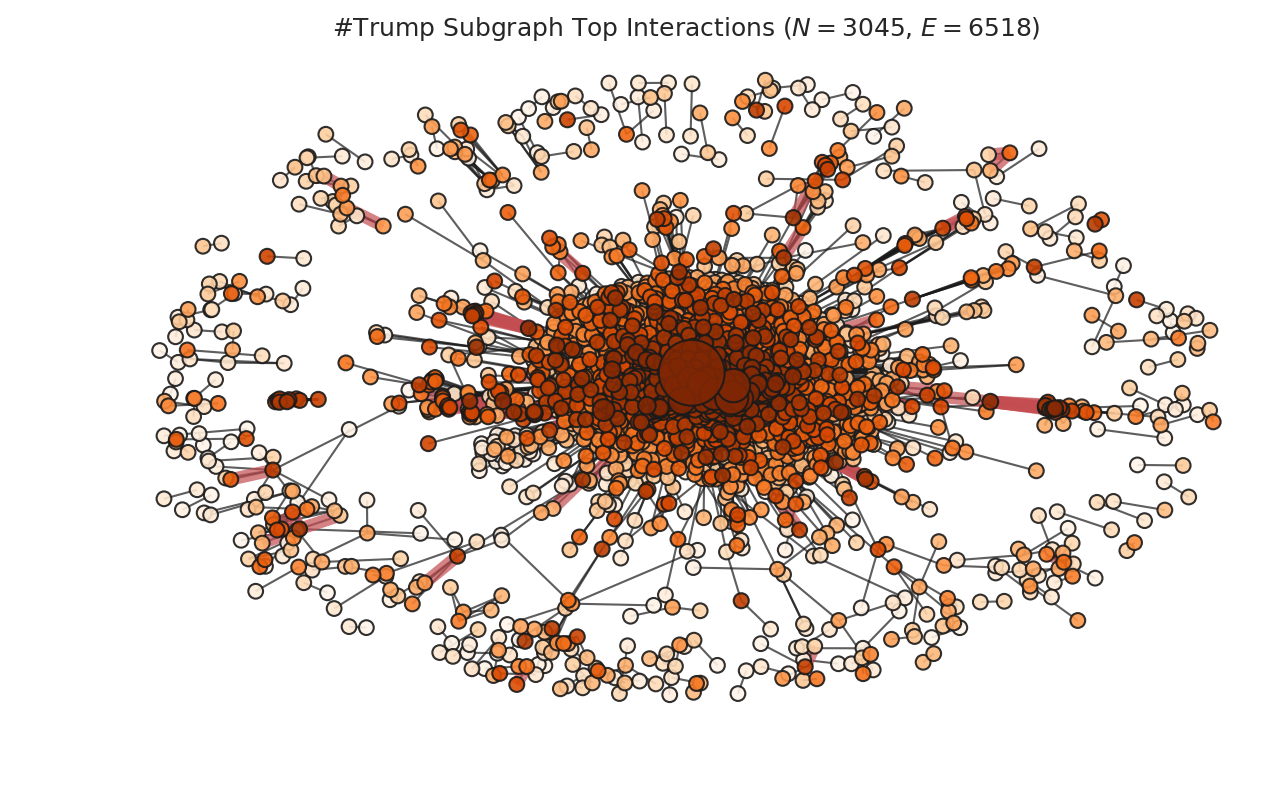

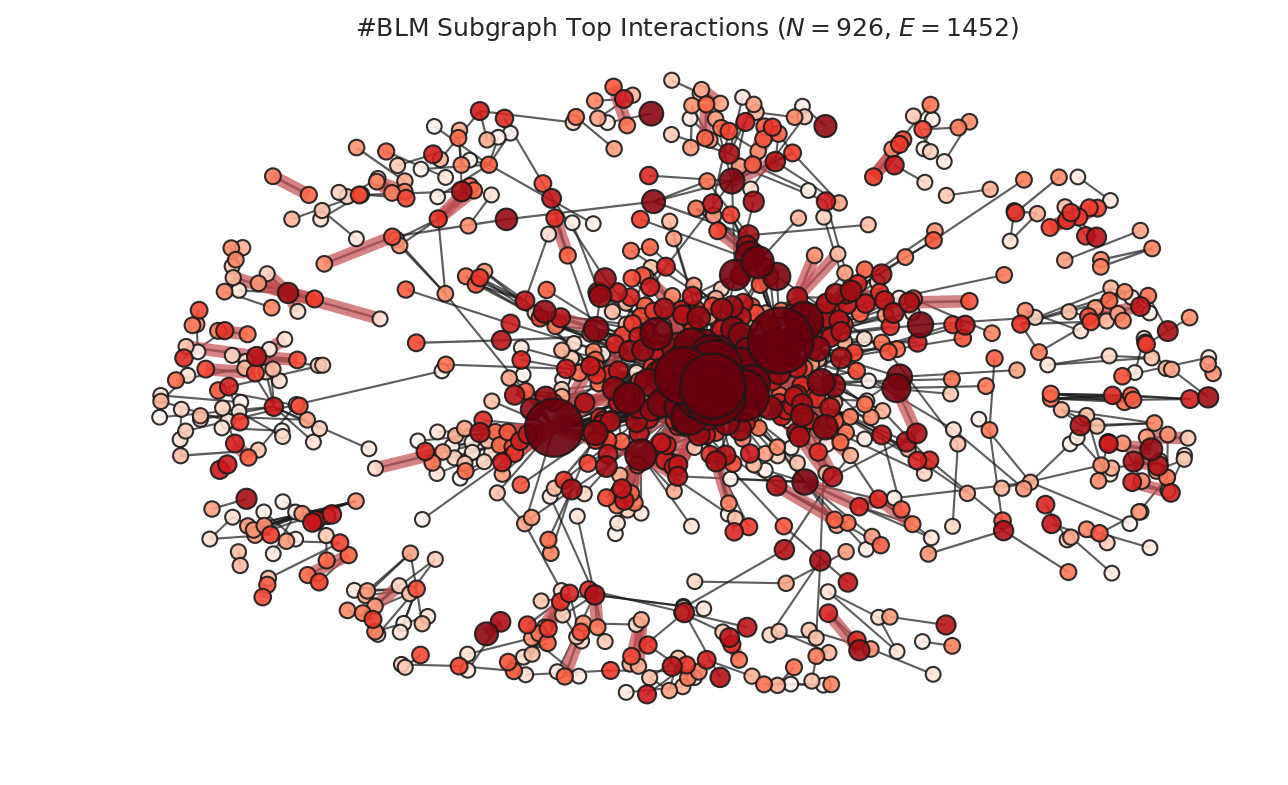

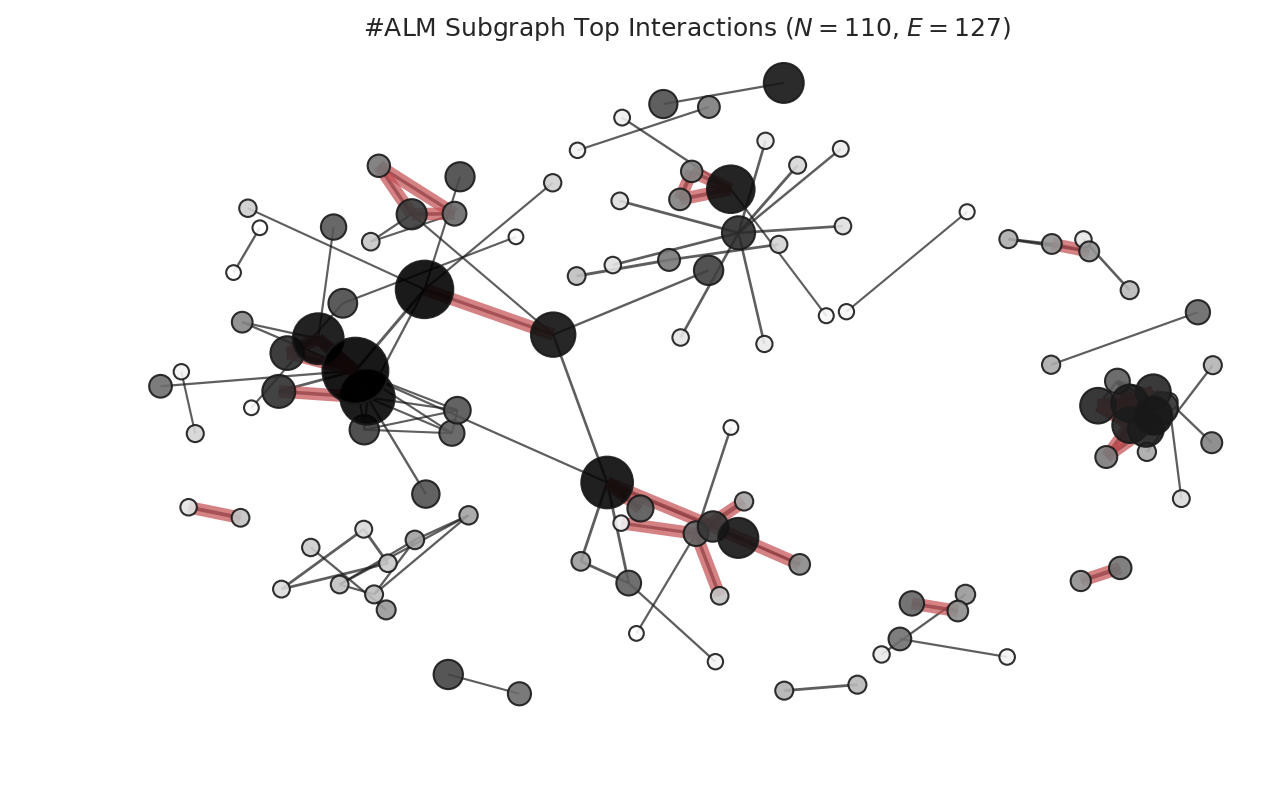

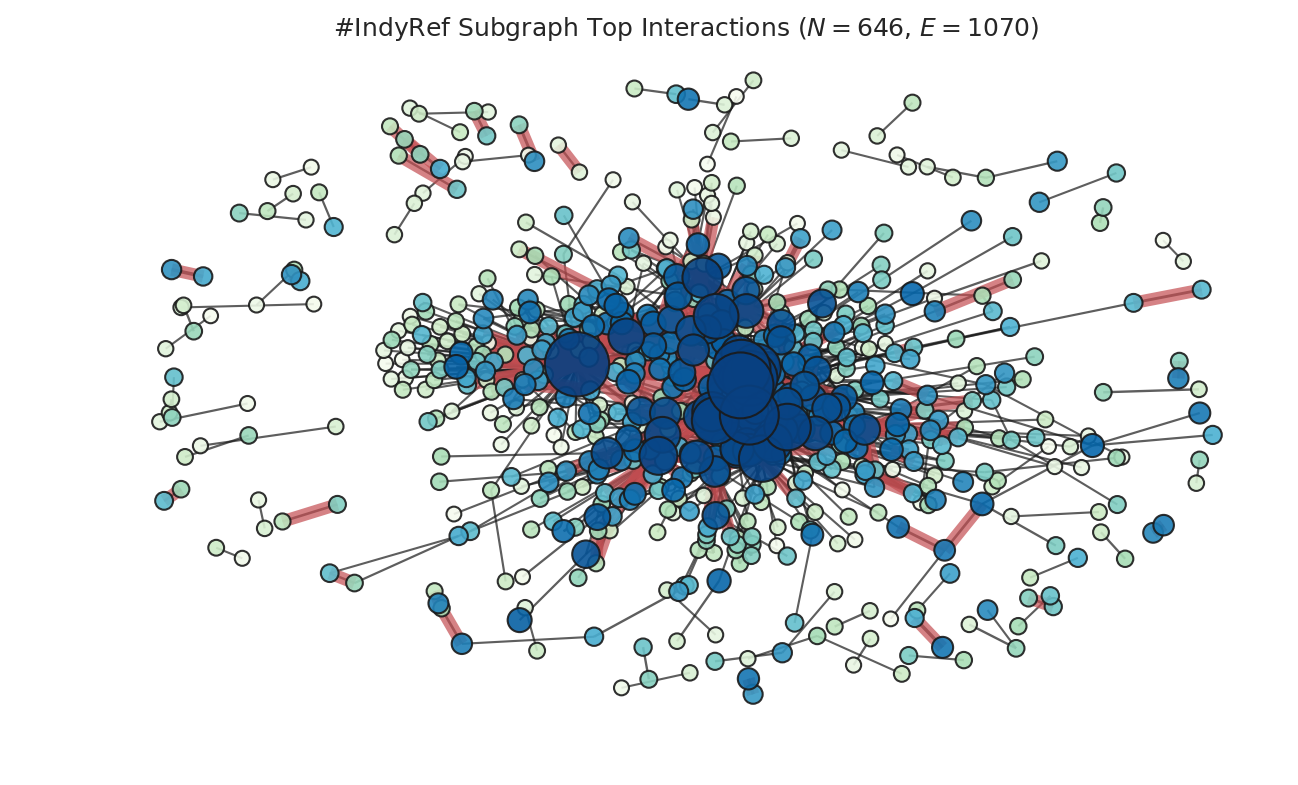

In [81]:
# Draw all subgraphs
for h,h_f in zip(hashtags, hashtags_full):
    draw_graph(h, h_f, hashtag_graph_df_dict, hashtag_cmap_dict)

## 2. Composing Graphs (Experiment)

In [29]:
# Build first graph
G = nx.Graph()
G.add_weighted_edges_from(hashtag_graph_df_dict["imwithher"]["Edges"].values)

H = nx.Graph()
H.add_weighted_edges_from(hashtag_graph_df_dict["makeamericagreatagain"]["Edges"].values)

F = nx.compose(G,H)

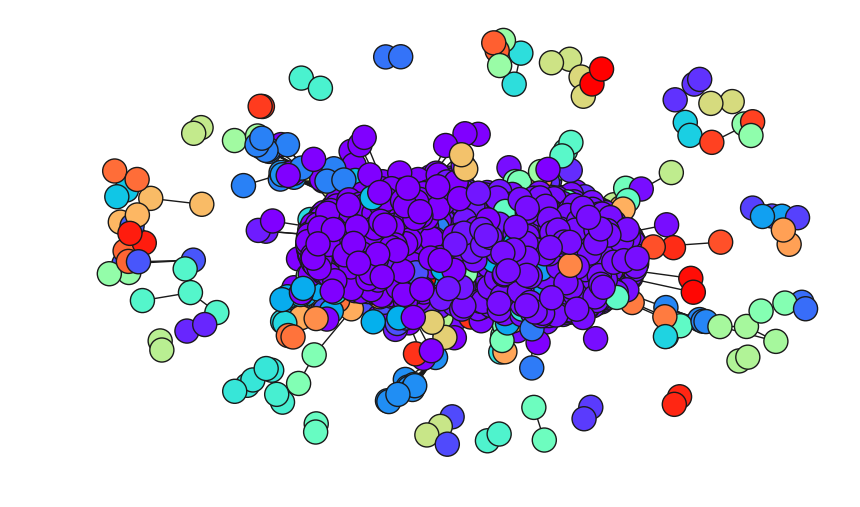

In [78]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.set_dpi(100)
ax.axis('off')
fig.set_tight_layout(False)

pos = nx.spring_layout(F,k=15/sqrt(len(F.nodes)))

nodes_list = [n for n in F.nodes()]

part = community.best_partition(F)
values = [part.get(n) for n in F.nodes()]

nx.draw_networkx(F, pos=pos, ax=ax, with_labels=False, nodelist=nodes_list, linewidths=1, edgecolors="k", cmap=plt.cm.rainbow, node_color=values)
plt.show()

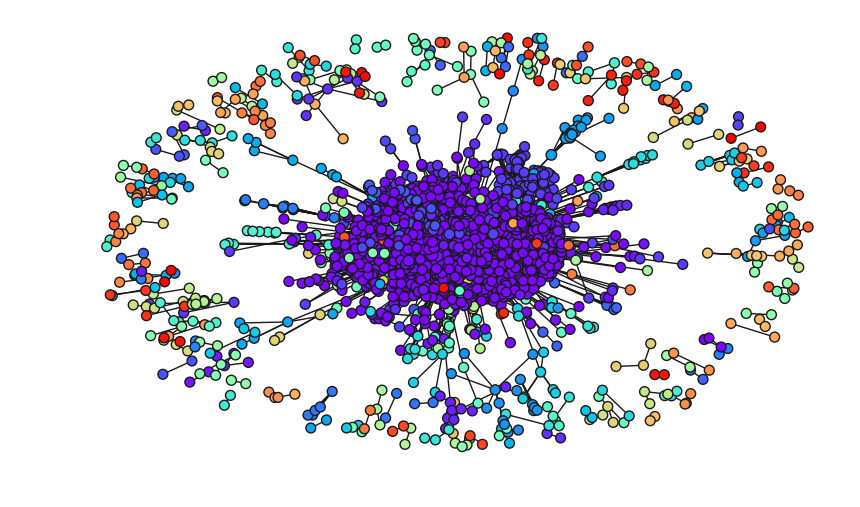

In [79]:
G = nx.Graph()
G.add_weighted_edges_from(hashtag_graph_df_dict["trump"]["Edges"].values)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.set_dpi(100)
ax.axis('off')
fig.set_tight_layout(False)

pos = nx.spring_layout(G,k=15/sqrt(len(F.nodes)))

nodes_attr = {}
for _,r in hashtag_graph_df_dict["trump"]["Nodes"].iterrows():
    nodes_attr[r["User"]] = r["Count"]
nodes_attr = {k:nodes_attr[k] for k in nodes_attr if G.has_node(k)}

nodes_list = [n for n in G.nodes()]
nodes_size = [nodes_attr[n] if n in nodes_attr else 100 for n in nodes_list]
nodes_size = [(1000-50)*(x-min(nodes_size))*1.0/(max(nodes_size)-min(nodes_size))+50 for x in nodes_size]

part = community.best_partition(G)
values = [part.get(n) for n in G.nodes()]

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, nodelist=nodes_list, node_size=nodes_size, linewidths=1, edgecolors="k", cmap=plt.cm.rainbow, node_color=values)
plt.show()

In [ ]:
CmtyV = snap.TCnComV()
modularity = snap.CommunityCNM(hashtag_subgraphs["blacklivesmatter"], CmtyV)
for Cmty in CmtyV:
    print("Community: ")
    for NI in Cmty:
        print(NI)
print("The modularity of the network is %f" % modularity)